In [1]:
%%javascript
utils.load_extension("execute_time/ExecuteTime")
utils.load_extension("collapsible_headings/main")

In [2]:
# Import candidate models
from doubt import Boot, QuantileRegressor, QuantileRegressionForest
from sklearn.linear_model import (
    LinearRegression,
    PoissonRegressor,
    GammaRegressor,
    HuberRegressor,
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

# Import datasets
from doubt.datasets import (
    Airfoil,
    Blog,
    Concrete,
    CPU,
    FacebookComments,
    FishBioconcentration,
    FishToxicity,
    ForestFire,
    NewTaipeiHousing,
    PowerPlant,
    Protein,
    Servo,
    SpaceShuttle,
    Yacht,
)

# Import external libraries
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange
from scipy.stats import ks_2samp, entropy, kruskal
import matplotlib.pyplot as plt
import itertools
from matplotlib import rcParams
%matplotlib inline
plt.style.use('fivethirtyeight')
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['figure.figsize'] = 16,8

plt.style.use("ggplot")
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import warnings
from collections import defaultdict
import seaborn as sns
import pdb

sns.set_theme(style="whitegrid")
import shap

# Import internal classes
from distributions import DistributionShift
from src.psi import psi

In [3]:
dataset_classes = [Airfoil, Concrete,
                   #FishToxicity, ForestFire, NewTaipeiHousing,
                   PowerPlant, Protein, Servo
                  ]

# Synthetic Data

In [4]:
data = dataset_classes[0]
SHIFTER = 1

In [5]:
def func(var: int = None):
    print(var)

In [6]:
func(var=4)

4


In [11]:
def explainability_plot(
    base_regressor: type,
    explainer:type,
    dataset: type,
    shift_param: int,
    test_size: int = 0.3,
    n_boots: int = 20,
    different_feature:int = None,
    **kwargs
):

    X_train, X_test, y_train, y_test = dataset().split(
        test_size=test_size, random_seed=42
    )

    # Scale the dataset
    standard_scaler = StandardScaler()
    standard_scaler.fit(X_train)
    X_train = standard_scaler.transform(X_train)
    X_test = standard_scaler.transform(X_test)


    # Initialize Shifter
    shifter = DistributionShift()
    shifter.fit(X_train)

    # Fit the regressor
    regressor = Boot(base_regressor(**kwargs))
    regressor.fit(X_train, y_train, n_boots=n_boots)

    # Select a combination of columns
    L = 3
    combinations = list(itertools.combinations(range(X_train.shape[1]), L))
    feat_shift = combinations[0]
    print("Shifted features: {} with param {}".format(feat_shift, shift_param))
    # Transform the test
    shifter.set_params(param=shift_param, cols=feat_shift)
    new_X_test = shifter.transform(X_test)

    # Predict uncertainty
    predictions, intervals = regressor.predict(new_X_test, uncertainty=0.05, n_boots=20)
    uncertainty = intervals[:, 1] - intervals[:, 0]

    # Explainability
    exp = explainer()
    exp.fit(X_test, uncertainty)
    explainer = shap.Explainer(exp)
    shap_values = explainer(new_X_test)

    # Plots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle("Identifying the source of model degradation bt train and test")

    ## Plot PSI
    ### Data Wrangling
    psi_dic = []
    for idx, col in enumerate(range(X_train.shape[1])):
        psi_dic.append(
            [
                "feat" + str(idx),
                psi(X_train[:,idx], new_X_test[:,idx]),
                ks_2samp(X_train[:,idx], new_X_test[:,idx]).statistic,
            ]
        )
    psi_dic = pd.DataFrame(psi_dic, columns=["column", "psi", "ks"])

    
    ### Figure
    ax1.title.set_text("Population Stability Index")
    ax1.set_ylabel("Population Stability Index")
    keys = psi_dic.sort_values("psi").column.values
    values = psi_dic.sort_values("psi").psi.values
    ax1.barh(keys, values)

    ### Figure
    ax2.title.set_text("Kolmogorov-Smirnov")
    ax2.set_ylabel("Population Stability Index")
    keys = psi_dic.sort_values("ks").column.values
    values = psi_dic.sort_values("ks").ks.values
    ax2.barh(keys, values)

    ## Plot Shap
    ax3 = shap.plots.bar(shap_values, show=False)
    plt.savefig("experiments/xai/shap_comparison.png")
    plt.show()

    # Plot distributions
    ## Shifted
    fig, axs = plt.subplots(1, L)
    fig.suptitle("Statistical difference bt train and shifted test")
    for i, c in enumerate(combinations[0]):
        axs[i].title.set_text("Dist feat:{}".format(c))
        sns.kdeplot(ax=axs[i], x=X_train[:,c], fill=True, label="train")
        sns.kdeplot(ax=axs[i], x=new_X_test[:,c], fill=True, label="test")
    plt.legend()
    plt.show()
    
    # Plot Additional distribution
    if different_feature!=None:
        try:
            plt.figure()
            plt.title("Statistical difference bt train and shifted test for feat:{}".format(different_feature))
            sns.kdeplot(x=X_train[:,different_feature], fill=True, label="train")
            sns.kdeplot( x=new_X_test[:,different_feature], fill=True, label="test")
            plt.legend()
            plt.show()
        except:
            pass
    
    


Shifted features: (0, 1, 2) with param 2


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


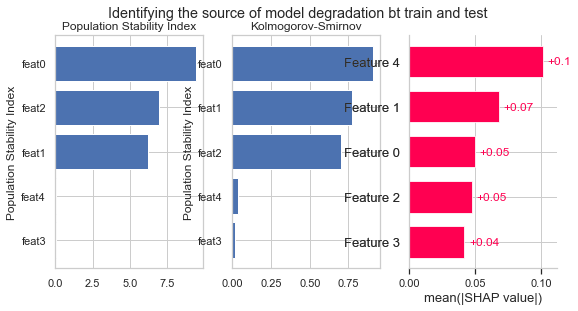

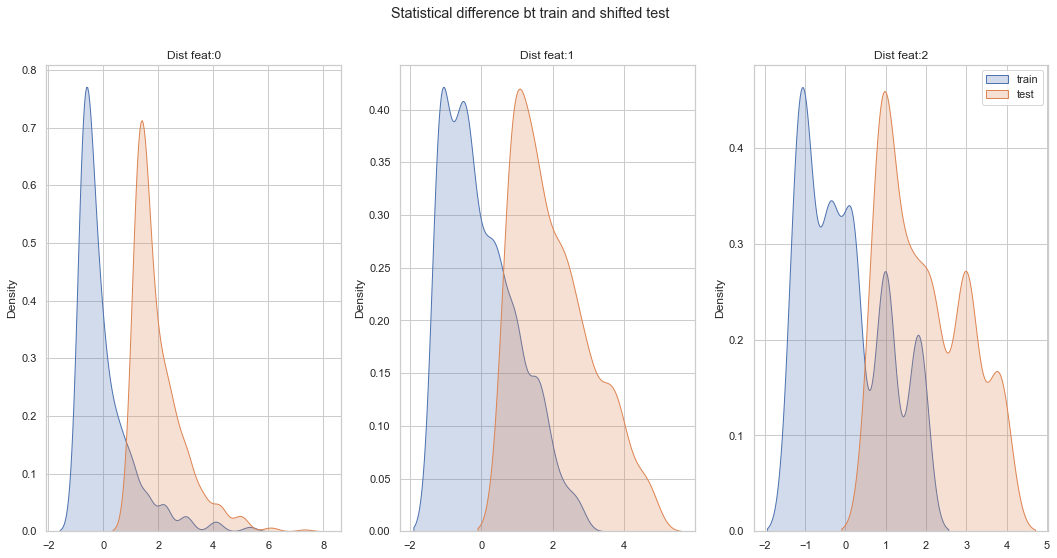

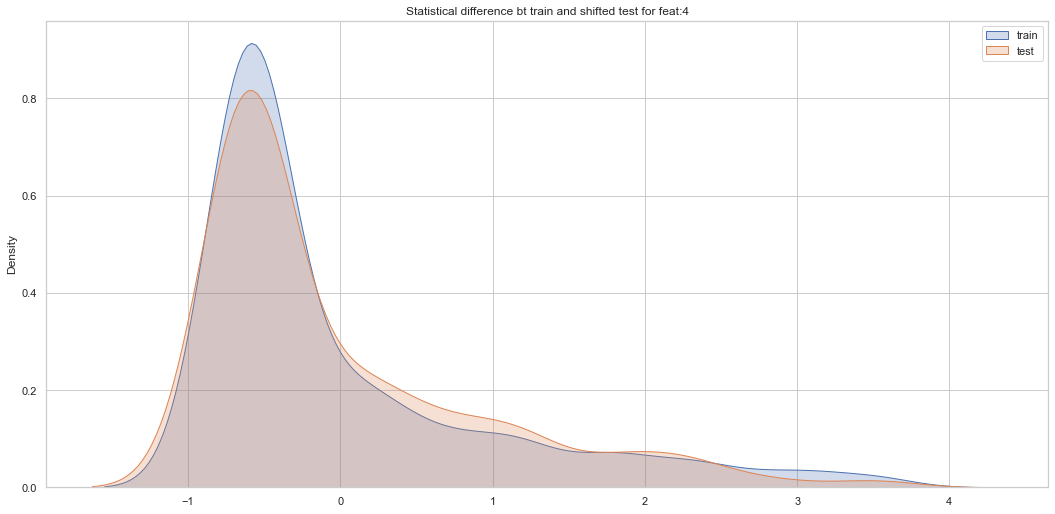

Shifted features: (0, 1, 2) with param 2


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


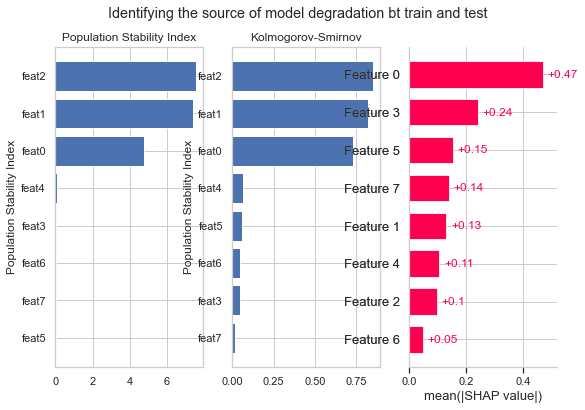

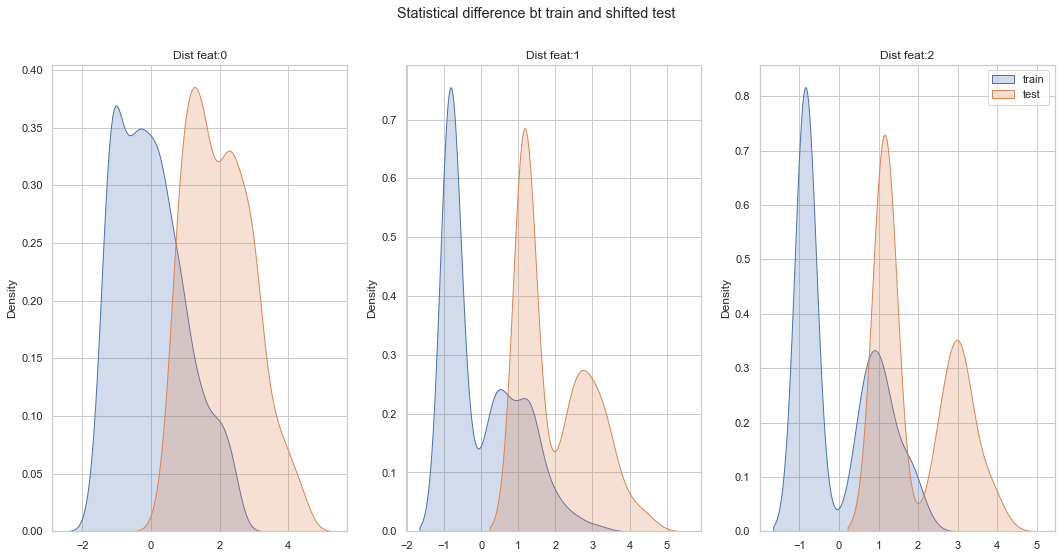

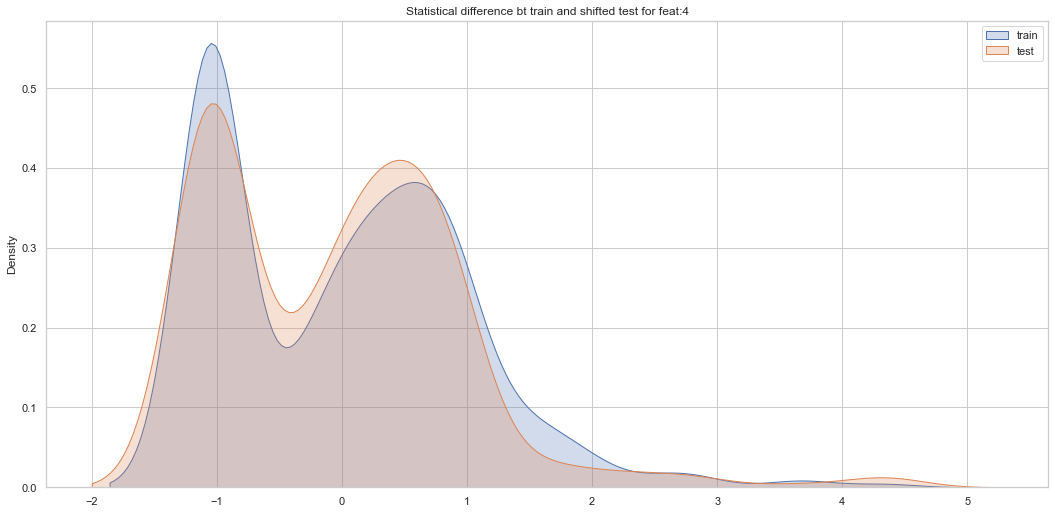

Shifted features: (0, 1, 2) with param 2


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


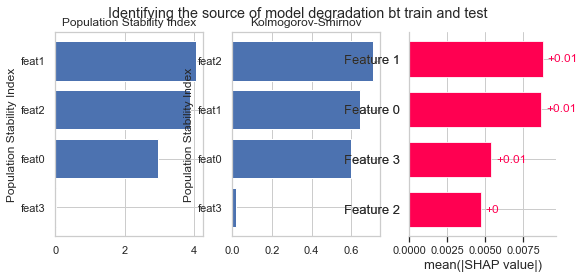

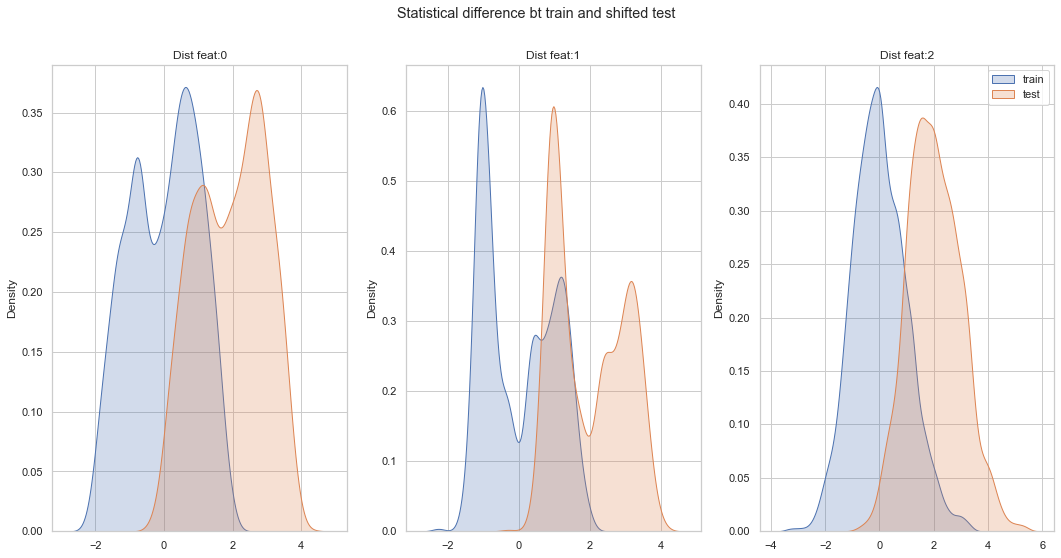

Shifted features: (0, 1, 2) with param 2


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


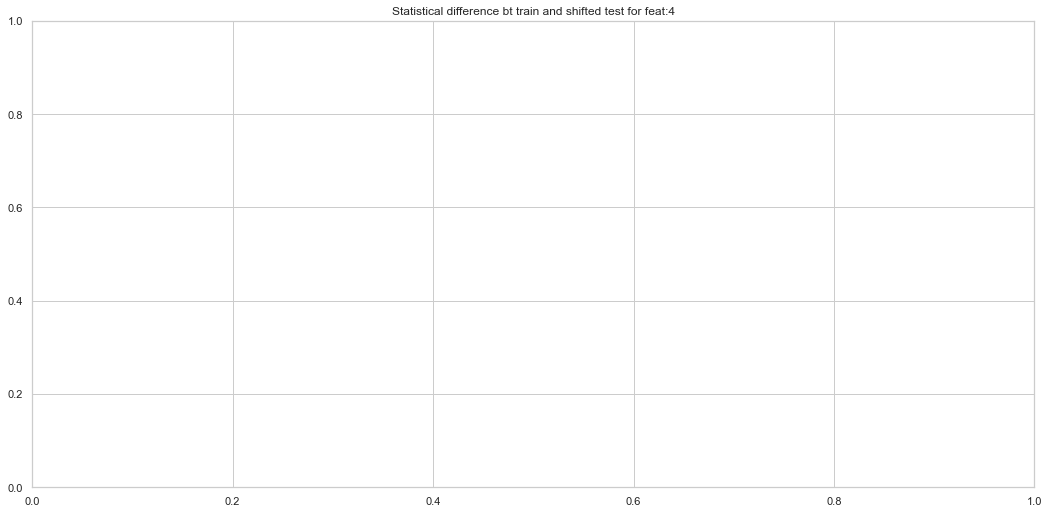

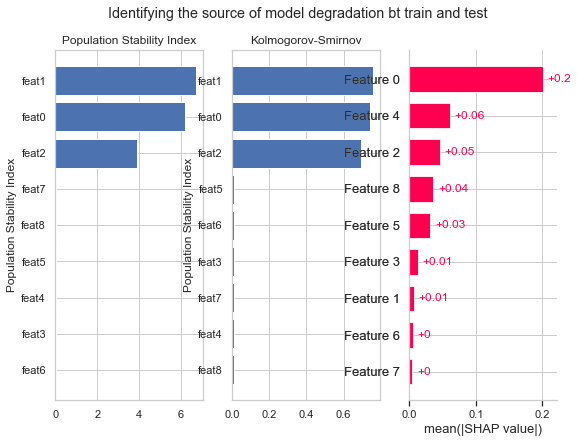

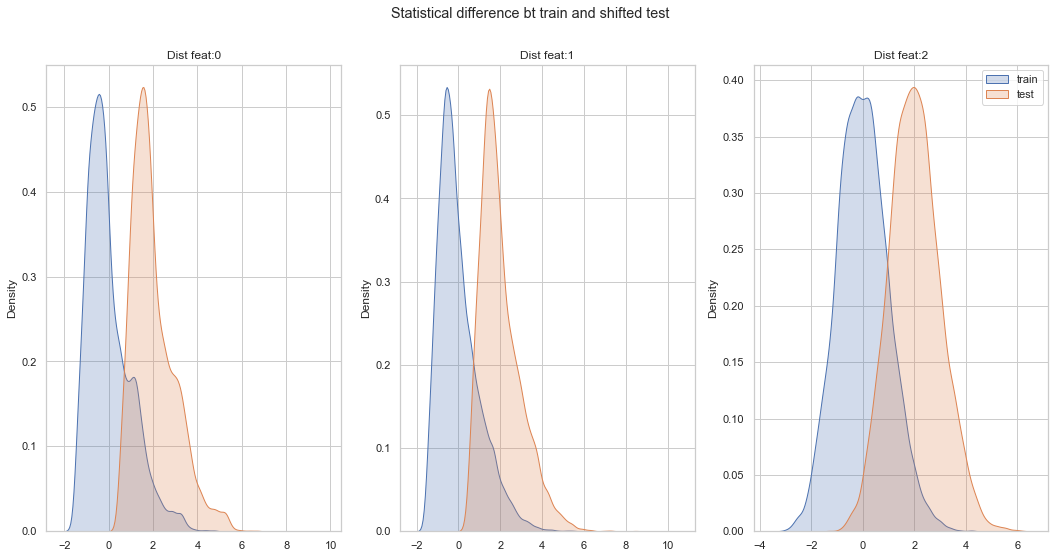

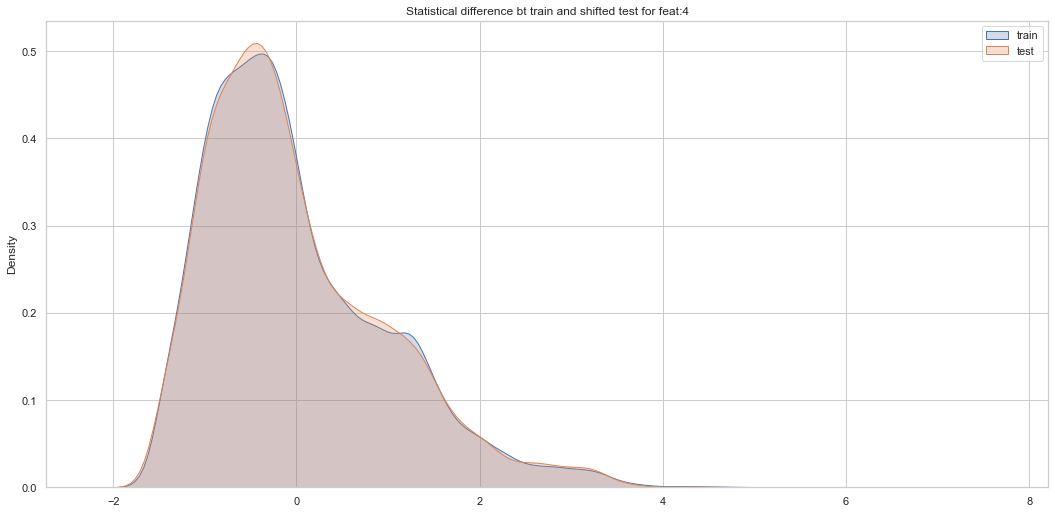

Shifted features: (0, 1, 2) with param 2


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


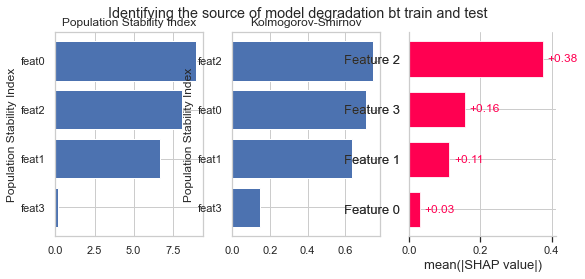

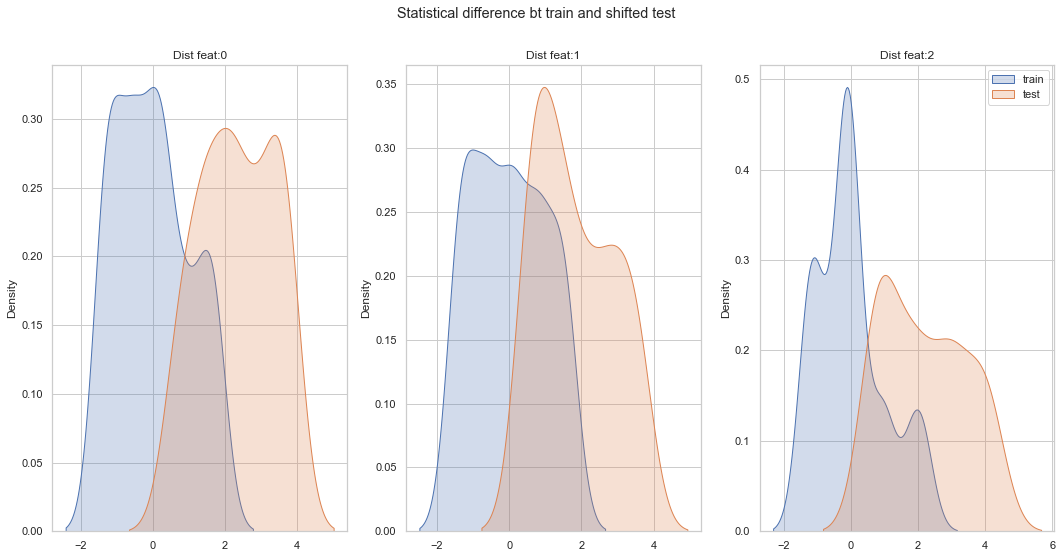

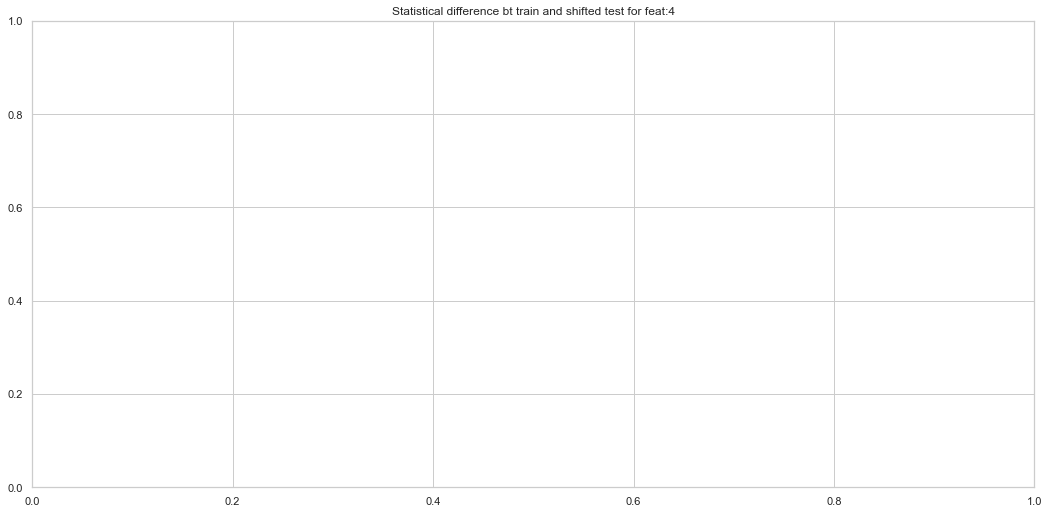

In [12]:
for data in dataset_classes:
    explainability_plot(
        dataset=data, base_regressor=LinearRegression, explainer=XGBRegressor,shift_param=2,n_boots=20,test_size=0.3,
        different_feature=4
    )


In [ ]:
kk



# Weather Shift


In [ ]:

train = pd.read_csv("data/train.csv", nrows=10_000)
test = pd.read_csv("data/dev_out.csv", nrows=10_000)

In [ ]:
cols = [
    "fact_time",
    "fact_latitude",
    "fact_longitude",
    "fact_temperature",
    "fact_cwsm_class",
    "climate",
    "cmc_timedelta_s",
]

In [ ]:
X_tr = train.drop(columns=cols).fillna(-1)
y_tr = train.fact_temperature

X_te = test.drop(columns=cols).fillna(-1)
y_te = test.fact_temperature

In [ ]:
standard_scaler = StandardScaler()

# Scale the dataset
standard_scaler.fit(X_tr)

X_tr = pd.DataFrame(standard_scaler.transform(X_tr), columns=X_tr.columns)
X_te = pd.DataFrame(standard_scaler.transform(X_te), columns=X_te.columns)

# Fit the regressor
# regressor = Boot(XGBRegressor(max_depth=5, n_estimators=50))
regressor = Boot(LinearRegression())
#regressor = Boot(MLPRegressor())

regressor.fit(X_tr, y_tr, n_boots=20)

In [ ]:
# Train preds
predictions, intervals = regressor.predict(X_tr, uncertainty=0.05)

In [ ]:
values = {}
values["uncertainty_train"] = intervals[:, 1] - intervals[:, 0]
values["mse_train"] = (predictions - y_tr) ** 2

In [ ]:
# Test preds
predictions, intervals = regressor.predict(X_te, uncertainty=0.05)
values["uncertainty_test"] = intervals[:, 1] - intervals[:, 0]
values["mse_test"] = (predictions - y_te) ** 2


d = pd.DataFrame(values)

In [ ]:
d = d.reindex(sorted(d.columns), axis=1)

d.describe()

In [ ]:
# Scaling the results
sc = StandardScaler()
sc.fit(d["uncertainty_train"].values.reshape(-1, 1))
d["uncertainty_train"] = sc.transform(d["uncertainty_train"].values.reshape(-1, 1))
d["uncertainty_test"] = sc.transform(d["uncertainty_test"].values.reshape(-1, 1))

sc = StandardScaler()
sc.fit(d["mse_train"].values.reshape(-1, 1))
d["mse_train"] = sc.transform(d["mse_train"].values.reshape(-1, 1))
d["mse_test"] = sc.transform(d["mse_test"].values.reshape(-1, 1))

In [ ]:
plt.figure()
sns.violinplot(data=d.drop(columns=["mse_train", "mse_test"]))
plt.title('Uncertainty estimation difference between train and test')
plt.show()

In [ ]:
sns.violinplot(data=d.drop(columns=["uncertainty_train", "uncertainty_test"]))

Very easy....

## Detecting the source of uncertainty

In [ ]:
# For whcih one? -- Linear 
reg = XGBRegressor()
# It wont work, i need to code a bit more for being able to accept LR
#reg = LinearRegression()
reg.fit(X_te, d["uncertainty_test"])

coefs = pd.DataFrame(
   reg.coef_,
   columns=['Coefficients'], index=X_tr.columns
)



coefs['Coefficients'] = np.abs(coefs['Coefficients'])
coefs.sort_values('Coefficients',ascending=False)

In [ ]:
mean_squared_error(reg.predict(X_te), d["uncertainty_test"])

In [ ]:
484.13129516116203

In [ ]:
explainer = shap.Explainer(reg)
shap_values = explainer(X_te)

# visualize the first prediction's explanation
# shap.plots.waterfall(shap_values[0])
plt.figure()
plt.title("Global Shap Values to indentify the source of uncertainty")
shap.plots.bar(shap_values, show=False)
plt.savefig("experiments/xai/shap.png")
plt.show()

In [ ]:
psi_dic = []
for c in X_tr.columns:
    psi_dic.append([c, psi(X_tr[c], X_te[c]),ks_2samp(X_tr[c], X_te[c]).statistic])



psi_dic = pd.DataFrame(psi_dic, columns=["column", "psi",'ks'])


plt.figure()
plt.title('Population Stability Index between train and test set')
plt.ylabel('Population Stability Index')
keys = psi_dic.sort_values("psi", ascending=False).head(10).column.values
values = psi_dic.sort_values("psi", ascending=False).head(10).psi.values

plt.hbar(keys, values)
plt.xticks(rotation=45)
plt.savefig('experiments/xai/psi.png')
plt.show()



In [ ]:
plt.figure()
plt.title('K-S between train and test set')
plt.ylabel('KS')
keys = psi_dic.sort_values("ks", ascending=False).head(10).column.values
values = psi_dic.sort_values("ks", ascending=False).head(10).ks.values

plt.bar(keys, values)
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Shap important feat
feat = 'gfs_a_vorticity'
plt.figure()
plt.title('Distribution for {}'.format(feat))
sns.kdeplot(train[feat].values, fill=True,label='train')
sns.kdeplot(test[feat].values,fill=True,label='test')
plt.legend()
plt.show()

In [ ]:
# K-S important feat
feat = 'gfs_temperature_5000'
plt.figure()
plt.title('Distribution for {}'.format(feat))
sns.kdeplot(train[feat].values, fill=True,label='train')
sns.kdeplot(test[feat].values,fill=True,label='test')
plt.legend()
plt.show()

In [ ]:
# Linreg important feat
feat = 'gfs_soil_temperature_available'
plt.figure()
plt.title('Distribution for {}'.format(feat))
sns.kdeplot(train[feat].values, fill=True,label='train')
sns.kdeplot(test[feat].values,fill=True,label='test')
plt.legend()
plt.show()


Yes! Shap says this feat is important. Distributions are similar!

Shap says temperature is not important for uncertainty (model degradation).

Which graphs do you like to present here? -- yes, For the paper, 

Demonstrate that in easy tasks both methods detect the same.
Shifting 3 features. 

Which graphs do you like to present here